## The first section of this notebook is based on the Tutorial from HuggingFace: Creating an AnnData Object from Tahoe-100M Dataset "https://huggingface.co/datasets/tahoebio/Tahoe-100M/blob/main/tutorials/loading_data.ipynb"


## Import Libraries

In [1]:
from datasets import load_dataset
from scipy.sparse import csr_matrix
import anndata
import pandas as pd
import pubchempy as pcp

/home/qile/miniconda3/envs/cs294w/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ensure to install the STATE fork with pip

In [ ]:
!pip install -e state

## Mapping records to anndata

This function takes in a generator that emits records from the Tahoe-100M huggingface dataset and returns an anndata object. Use the `sample_size` argument to specify the number of records you need. You can also create a new generator using the `dataset.filter` function to only emit records that match a certain filter (eg: for a specific drug/plate/sample).

If you'd like to create a DataLoader for an ML training application, it's likely best to use the data in it's native format without interfacing with anndata.

In [2]:
def create_anndata_from_generator(generator, gene_vocab, sample_size=None):
    sorted_vocab_items = sorted(gene_vocab.items())
    token_ids, gene_names = zip(*sorted_vocab_items)
    token_id_to_col_idx = {token_id: idx for idx, token_id in enumerate(token_ids)}

    data, indices, indptr = [], [], [0]
    obs_data = []

    for i, cell in enumerate(generator):
        if sample_size is not None and i >= sample_size:
            break
        genes = cell['genes']
        expressions = cell['expressions']
        if expressions[0] < 0:
            genes = genes[1:]
            expressions = expressions[1:]

        col_indices = [token_id_to_col_idx[gene] for gene in genes if gene in token_id_to_col_idx]
        valid_expressions = [expr for gene, expr in zip(genes, expressions) if gene in token_id_to_col_idx]

        data.extend(valid_expressions)
        indices.extend(col_indices)
        indptr.append(len(data))

        obs_entry = {k: v for k, v in cell.items() if k not in ['genes', 'expressions']}
        obs_data.append(obs_entry)

    expr_matrix = csr_matrix((data, indices, indptr), shape=(len(indptr) - 1, len(gene_names)))
    obs_df = pd.DataFrame(obs_data)

    adata = anndata.AnnData(X=expr_matrix, obs=obs_df)
    adata.var.index = pd.Index(gene_names, name='ensembl_id')

    return adata


## Load Tahoe-100M Dataset

In [3]:
tahoe_100m_ds = load_dataset('vevotx/Tahoe-100M', streaming=True, split='train')

## Load Gene Metadata

The gene metadata contains the mapping between the integer token IDs used in the dataset and standard identifiers for genes (ensembl IDs and HGNC gene symbols)

In [4]:
gene_metadata = load_dataset("vevotx/Tahoe-100M", name="gene_metadata", split="train")
gene_vocab = {entry["token_id"]: entry["gene_symbol"] for entry in gene_metadata}

## Create AnnData Object

In [5]:
adata = create_anndata_from_generator(tahoe_100m_ds, gene_vocab, sample_size=1000)
adata

/home/qile/miniconda3/envs/cs294w/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


AnnData object with n_obs × n_vars = 1000 × 62710
    obs: 'drug', 'sample', 'BARCODE_SUB_LIB_ID', 'cell_line_id', 'moa-fine', 'canonical_smiles', 'pubchem_cid', 'plate'

## Inspect Metadata (`adata.obs`)

In [6]:
adata.obs.head()

,drug,sample,BARCODE_SUB_LIB_ID,cell_line_id,moa-fine,canonical_smiles,pubchem_cid,plate
0,8-Hydroxyquinoline,smp_1783,01_001_052-lib_1105,CVCL_0480,unclear,C1=CC2=C(C(=C1)O)N=CC=C2,1923.0,plate4
1,8-Hydroxyquinoline,smp_1783,01_001_105-lib_1105,CVCL_0546,unclear,C1=CC2=C(C(=C1)O)N=CC=C2,1923.0,plate4
2,8-Hydroxyquinoline,smp_1783,01_001_165-lib_1105,CVCL_1717,unclear,C1=CC2=C(C(=C1)O)N=CC=C2,1923.0,plate4
3,8-Hydroxyquinoline,smp_1783,01_003_094-lib_1105,CVCL_1717,unclear,C1=CC2=C(C(=C1)O)N=CC=C2,1923.0,plate4
4,8-Hydroxyquinoline,smp_1783,01_003_164-lib_1105,CVCL_1056,unclear,C1=CC2=C(C(=C1)O)N=CC=C2,1923.0,plate4


## Enrich with Sample Metadata

Although the main data contains several metadata fields, there are some additional columns (such as drug concentration) which are omitted to reduce the size of the data. If they are needed, they may be fetched using the sample_metadata.

In [7]:
sample_metadata = load_dataset("vevotx/Tahoe-100M","sample_metadata", split="train").to_pandas()
adata.obs = pd.merge(adata.obs, sample_metadata.drop(columns=["drug","plate"]), on="sample")
adata.obs.head()

/home/qile/miniconda3/envs/cs294w/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


,drug,sample,BARCODE_SUB_LIB_ID,cell_line_id,moa-fine,canonical_smiles,pubchem_cid,plate,mean_gene_count,mean_tscp_count,mean_mread_count,mean_pcnt_mito,drugname_drugconc
0,8-Hydroxyquinoline,smp_1783,01_001_052-lib_1105,CVCL_0480,unclear,C1=CC2=C(C(=C1)O)N=CC=C2,1923.0,plate4,1478.268171,2341.339094,2738.463797,0.023783,"[('8-Hydroxyquinoline', 0.05, 'uM')]"
1,8-Hydroxyquinoline,smp_1783,01_001_105-lib_1105,CVCL_0546,unclear,C1=CC2=C(C(=C1)O)N=CC=C2,1923.0,plate4,1478.268171,2341.339094,2738.463797,0.023783,"[('8-Hydroxyquinoline', 0.05, 'uM')]"
2,8-Hydroxyquinoline,smp_1783,01_001_165-lib_1105,CVCL_1717,unclear,C1=CC2=C(C(=C1)O)N=CC=C2,1923.0,plate4,1478.268171,2341.339094,2738.463797,0.023783,"[('8-Hydroxyquinoline', 0.05, 'uM')]"
3,8-Hydroxyquinoline,smp_1783,01_003_094-lib_1105,CVCL_1717,unclear,C1=CC2=C(C(=C1)O)N=CC=C2,1923.0,plate4,1478.268171,2341.339094,2738.463797,0.023783,"[('8-Hydroxyquinoline', 0.05, 'uM')]"
4,8-Hydroxyquinoline,smp_1783,01_003_164-lib_1105,CVCL_1056,unclear,C1=CC2=C(C(=C1)O)N=CC=C2,1923.0,plate4,1478.268171,2341.339094,2738.463797,0.023783,"[('8-Hydroxyquinoline', 0.05, 'uM')]"


## Add Drug Metadata

The drug metadata contains additional information for the compounds used in Tahoe-100M. See the dataset card and our [paper](https://www.biorxiv.org/content/10.1101/2025.02.20.639398v1) for more information about how this information was generated.

In [8]:
drug_metadata = load_dataset("vevotx/Tahoe-100M","drug_metadata", split="train").to_pandas()
adata.obs = pd.merge(adata.obs, drug_metadata.drop(columns=["canonical_smiles","pubchem_cid","moa-fine"]), on="drug")
adata.obs.head()

/home/qile/miniconda3/envs/cs294w/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


,drug,sample,BARCODE_SUB_LIB_ID,cell_line_id,moa-fine,canonical_smiles,pubchem_cid,plate,mean_gene_count,mean_tscp_count,mean_mread_count,mean_pcnt_mito,drugname_drugconc,targets,moa-broad,human-approved,clinical-trials,gpt-notes-approval
0,8-Hydroxyquinoline,smp_1783,01_001_052-lib_1105,CVCL_0480,unclear,C1=CC2=C(C(=C1)O)N=CC=C2,1923.0,plate4,1478.268171,2341.339094,2738.463797,0.023783,"[('8-Hydroxyquinoline', 0.05, 'uM')]",None,unclear,no,yes,"Used in some clinical trial formulations, not ..."
1,8-Hydroxyquinoline,smp_1783,01_001_105-lib_1105,CVCL_0546,unclear,C1=CC2=C(C(=C1)O)N=CC=C2,1923.0,plate4,1478.268171,2341.339094,2738.463797,0.023783,"[('8-Hydroxyquinoline', 0.05, 'uM')]",None,unclear,no,yes,"Used in some clinical trial formulations, not ..."
2,8-Hydroxyquinoline,smp_1783,01_001_165-lib_1105,CVCL_1717,unclear,C1=CC2=C(C(=C1)O)N=CC=C2,1923.0,plate4,1478.268171,2341.339094,2738.463797,0.023783,"[('8-Hydroxyquinoline', 0.05, 'uM')]",None,unclear,no,yes,"Used in some clinical trial formulations, not ..."
3,8-Hydroxyquinoline,smp_1783,01_003_094-lib_1105,CVCL_1717,unclear,C1=CC2=C(C(=C1)O)N=CC=C2,1923.0,plate4,1478.268171,2341.339094,2738.463797,0.023783,"[('8-Hydroxyquinoline', 0.05, 'uM')]",None,unclear,no,yes,"Used in some clinical trial formulations, not ..."
4,8-Hydroxyquinoline,smp_1783,01_003_164-lib_1105,CVCL_1056,unclear,C1=CC2=C(C(=C1)O)N=CC=C2,1923.0,plate4,1478.268171,2341.339094,2738.463797,0.023783,"[('8-Hydroxyquinoline', 0.05, 'uM')]",None,unclear,no,yes,"Used in some clinical trial formulations, not ..."


## Drug Info from PubChem

We also provide the pubchem IDs for the compounds in Tahoe, this can be used to querry additional information as needed.

In [9]:
drug_name = adata.obs["drug"].values[0]
cid = int(float(adata.obs["pubchem_cid"].values[0]))
compound = pcp.Compound.from_cid(cid)

print(f"drug name: {drug_name}")
print(f"drug synonyms: {compound.synonyms[:10]}")
print(f"formula: {compound.molecular_formula}")
print(f"isomeric_smiles: {compound.isomeric_smiles}")
print(f"mass: {compound.exact_mass}")

drug name: 8-Hydroxyquinoline
drug synonyms: ['8-HYDROXYQUINOLINE', 'quinolin-8-ol', '148-24-3', '8-quinolinol', 'Oxyquinoline', 'Oxine', 'Quinophenol', 'Oxychinolin', 'Phenopyridine', '8-Quinol']
formula: C9H7NO
isomeric_smiles: C1=CC2=C(C(=C1)O)N=CC=C2
mass: 145.052763847


/tmp/ipykernel_593009/2869972523.py:8: PubChemPyDeprecationWarning: isomeric_smiles is deprecated: Use smiles instead
  print(f"isomeric_smiles: {compound.isomeric_smiles}")


## Load Cell Line Metadata
The cell-line metadata contains additional identifiers for the
cell-lines used in Tahoe (eg: Depmap-IDs) as well as a curated list of driver mutations for each cell line. This information can be used for instance to train genotype aware models on the Tahoe data.

In [10]:
cell_line_metadata = load_dataset("vevotx/Tahoe-100M","cell_line_metadata", split="train").to_pandas()
cell_line_metadata.head()

,cell_name,Cell_ID_DepMap,Cell_ID_Cellosaur,Organ,Driver_Gene_Symbol,Driver_VarZyg,Driver_VarType,Driver_ProtEffect_or_CdnaEffect,Driver_Mech_InferDM,Driver_GeneType_DM
0,A549,ACH-000681,CVCL_0023,Lung,CDKN2A,Hom,Deletion,DEL,LoF,Suppressor
1,A549,ACH-000681,CVCL_0023,Lung,CDKN2B,Hom,Deletion,DEL,LoF,Suppressor
2,A549,ACH-000681,CVCL_0023,Lung,KRAS,Hom,Missense,p.G12S,GoF,Oncogene
3,A549,ACH-000681,CVCL_0023,Lung,SMARCA4,Hom,Frameshift,p.Q729fs,LoF,Suppressor
4,A549,ACH-000681,CVCL_0023,Lung,STK11,Hom,Stopgain,p.Q37*,LoF,Suppressor


### Original Tutorial End, below is mannually added work

Import packages (some of them may be imported already)

In [13]:
# # !pip install datasets anndata scipy pandas pubchempy
# !pip install scanpy scikit-learn matplotlib seaborn
# # install the STATE model package and its dependencies
# !pip install git+https://github.com/ArcInstitute/state.git

In [11]:
from datasets import load_dataset
from scipy.sparse import csr_matrix, hstack, csr_matrix as sp_csr_matrix
from sklearn.decomposition import NMF
import anndata
import pandas as pd
import pubchempy as pcp
import numpy as np
import torch
import scanpy as sc
import state.tx # For model classes
from huggingface_hub import snapshot_download
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances

In [12]:
tahoe_stream = load_dataset('vevotx/Tahoe-100M', streaming=True, split='train')

### Getting Control Cells from Tahoe100M

In [10]:
def get_control_stream_optimized(dataset, n_cells: int):
  '''Filter for DMSO (vehicle control) cells'''
  # shuffle to break clusters (the data was sorted by drug origially)
  shuffled_ds = dataset.shuffle(seed=42, buffer_size=10000)# buffer_size=10000 downloads 10k rows into RAM to pick random ones

  # filter for DMSO (because paper said that 'DMSO_TF'--> vehicle controls)
  # use 'DMSO' in ... covers 'DMSO_TF'
  control_stream = shuffled_ds.filter(lambda x: x['drug'] == 'DMSO_TF')
  return control_stream.take(n_cells) # further subsample for cNMF prototyping


In [13]:
# 2-3k controls takes ~60s
control_stream = get_control_stream_optimized(tahoe_stream, n_cells=3000)
adata_control = create_anndata_from_generator(control_stream, gene_vocab, sample_size=3000)
print(f"Control Atlas Loaded: {adata_control.shape}")

Control Atlas Loaded: (3000, 62710)


/home/qile/miniconda3/envs/cs294w/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


In [16]:
# adata_control = anndata.read_h5ad("data/inputs/controls_raw_3k.h5ad")

In [24]:
adata_control.obs["drugname_drugconc"] = "[('DMSO_TF', 0.0, 'uM')]" # this is the correct name for control in pert_onehot_map, loaded with weights_only=Falsea
# this is in the drug metadata dataframe too

adata_control.write_h5ad("data/inputs/controls_raw_3k.h5ad")

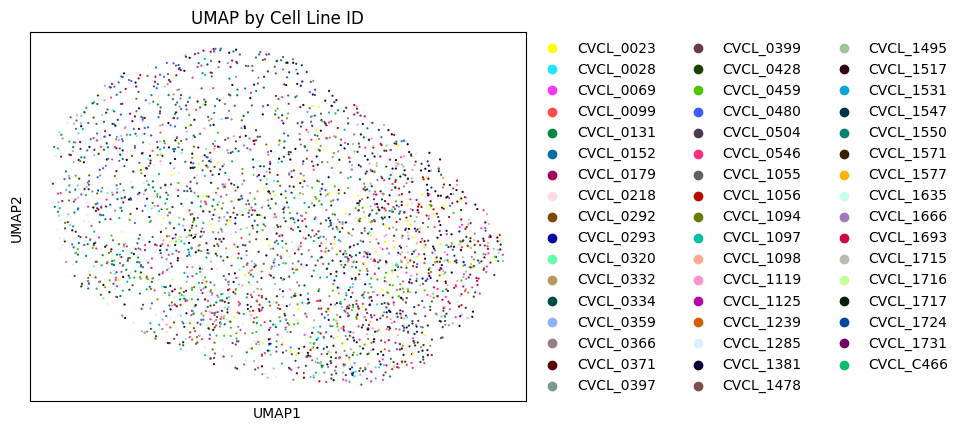

In [96]:
# Compute UMAP
sc.pp.neighbors(adata_control, n_neighbors=15, use_rep='X')
sc.tl.umap(adata_control)

# Plot UMAP colored by cell_line_id
sc.pl.umap(adata_control, color='cell_line_id', size=10, frameon=True, title='UMAP by Cell Line ID')

## load the pre-trained State Transition (ST) model trained on the Tahoe data

In [19]:
model_path = snapshot_download(repo_id="arcinstitute/ST-Tahoe", local_dir="./ST-Tahoe", max_workers=16)
print(f"model downloaded to {model_path}") # saved to a folder named 'ST-Tahoe'

Fetching 14 files: 100%|██████████| 14/14 [11:12<00:00, 48.07s/it]

model downloaded to /home/qile/personal/classes/cs194-wagner-fa25/final-project/main-repo/ST-Tahoe


In [17]:
# load the checkpoint
download_dir = "./ST-Tahoe"
ckpt_files = [f for f in os.listdir(download_dir) if f.endswith(".ckpt")]

In [18]:
# test to check the location
if not ckpt_files:
    raise FileNotFoundError("could not find any .ckpt file in the downloaded ST-Tahoe folder.")

In [19]:
checkpoint_path = os.path.join(download_dir, ckpt_files[0]) if "/" not in ckpt_files[0] else ckpt_files[0]
print(f"found checkpoint: {checkpoint_path}")

# check how is the model loaded
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"load model on {device}")

found checkpoint: ./ST-Tahoe/final_from_preprint.ckpt
load model on cuda


In [18]:
# get the state HVGs
import pickle
HVG_NAMES = pickle.load(open('ST-Tahoe/var_dims.pkl', 'rb'))['gene_names']
HVG_NAMES

array(['CFH', 'GCLC', 'CFTR', ..., 'ACACA', 'SPDYE15', 'SOD2'],
      shape=(2000,), dtype=object)

In [19]:
# make preprocessing function that's identical to STATE's:
# https://github.com/ArcInstitute/state/blob/main/src/state/_cli/_tx/_preprocess_train.py

import scanpy as sc

def preprocess_state(adata):
    sc.pp.normalize_total(adata) # TODO - the total target is not specified in STATE code
    sc.pp.log1p(adata)
    return adata

def filter_state_hvgs(adata):
    sc.pp.highly_variable_genes(adata, n_top_genes=len(HVG_NAMES))
    adata.var['highly_variable'] = adata.var_names.isin(HVG_NAMES)
    adata.obsm["X_hvg"] = adata[:, adata.var.highly_variable].X.toarray() # FIXME names dont match
    return adata

def prep_for_state(adata):
    adata = preprocess_state(adata)
    adata = filter_state_hvgs(adata)
    return adata

In [29]:
adata_control = preprocess_state(adata_control)
adata_filtered = filter_state_hvgs(adata_control.copy())
adata_filtered.write_h5ad("data/inputs/controls_processed_3k.h5ad")

In [20]:
# adata_filtered = anndata.read_h5ad("data/inputs/controls_processed_3k.h5ad")

STATE Prediction on regular control cells

In [35]:
!state tx infer_controls \
  --adata data/inputs/controls_processed_3k.h5ad \
  --model-dir ./ST-Tahoe \
  --target-pert "[('DMSO_TF', 0.0, 'uM')]" \
  --embed-key X_hvg \
  --output data/outputs/controls.h5ad

==> STATE: Apply '[('DMSO_TF', 0.0, 'uM')]' to control cells
Loading model from ./ST-Tahoe/final_from_preprint.ckpt
StateTransitionPerturbationModel(
  (loss_fn): SamplesLoss()
  (pert_encoder): Sequential(
    (0): Linear(in_features=1138, out_features=1488, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1488, out_features=1488, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=1488, out_features=1488, bias=True)
    (7): GELU(approximate='none')
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=1488, out_features=1488, bias=True)
  )
  (basal_encoder): Sequential(
    (0): Linear(in_features=2000, out_features=1488, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1488, out_features=1488, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.1, inplace=False)
    (6): 

In [21]:
adata_filtered_pred = anndata.read_h5ad("data/outputs/controls.h5ad")

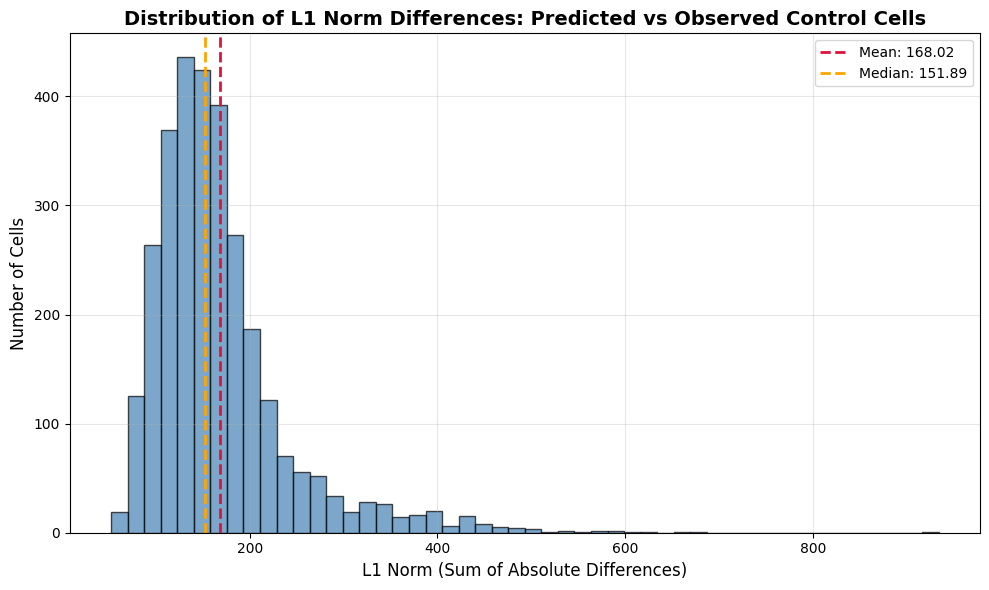

L1 Norm Statistics:
  Mean: 168.0163
  Median: 151.8917
  Std Dev: 74.9930
  Min: 52.3200
  Max: 933.6919


In [36]:
diffs_control = adata_filtered_pred.obsm["X_hvg_pred"] - adata_filtered_pred.obsm["X_hvg"]

# Calculate L1 norm (sum of absolute differences) for each cell
control_l1_norms = np.abs(diffs).sum(axis=1)

# Create histogram of L1 norm differences
plt.figure(figsize=(10, 6))
plt.hist(l1_norms, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('L1 Norm (Sum of Absolute Differences)', fontsize=12)
plt.ylabel('Number of Cells', fontsize=12)
plt.title('Distribution of L1 Norm Differences: Predicted vs Observed Control Cells', fontsize=14, weight='bold')
plt.axvline(l1_norms.mean(), color='crimson', linestyle='--', linewidth=2, label=f'Mean: {l1_norms.mean():.2f}')
plt.axvline(np.median(l1_norms), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(l1_norms):.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"L1 Norm Statistics:")
print(f"  Mean: {l1_norms.mean():.4f}")
print(f"  Median: {np.median(l1_norms):.4f}")
print(f"  Std Dev: {l1_norms.std():.4f}")
print(f"  Min: {l1_norms.min():.4f}")
print(f"  Max: {l1_norms.max():.4f}")

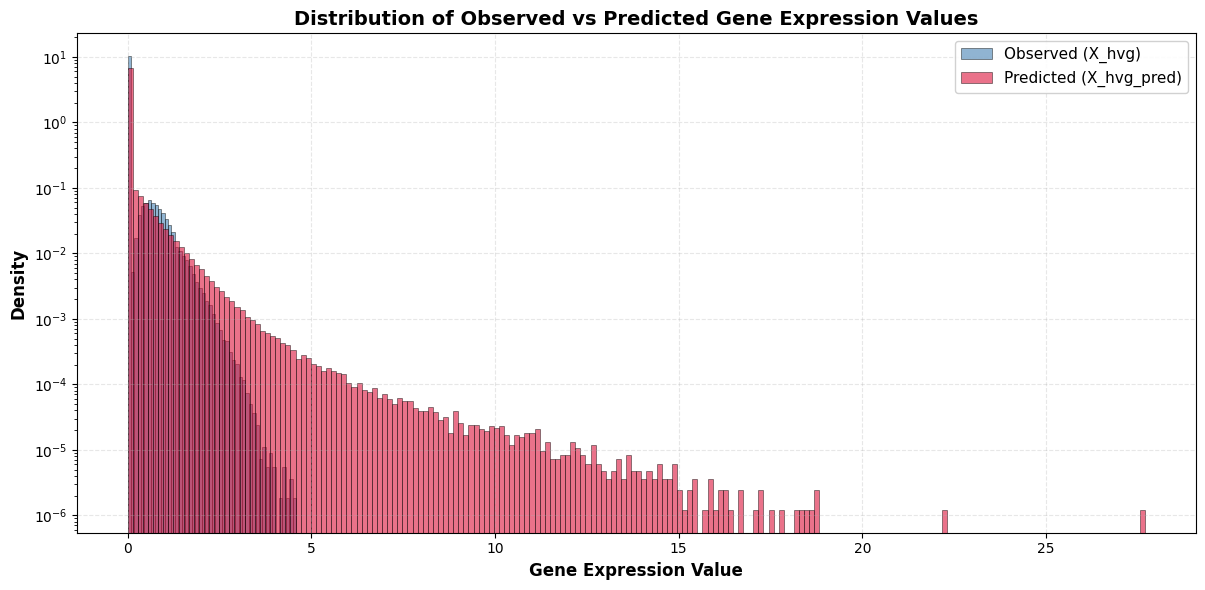

In [43]:
# Overlay histograms of observed vs predicted gene expression values
plt.figure(figsize=(12, 6))

# Flatten the arrays to get all expression values
observed_values = adata_filtered_pred.obsm["X_hvg"].flatten()
predicted_values = adata_filtered_pred.obsm["X_hvg_pred"].flatten()

# Create overlaid histograms
plt.hist(observed_values, bins=50, alpha=0.6, color='steelblue', 
         label='Observed (X_hvg)', edgecolor='black', linewidth=0.5, density=True)
plt.hist(predicted_values, bins=200, alpha=0.6, color='crimson', 
         label='Predicted (X_hvg_pred)', edgecolor='black', linewidth=0.5, density=True)

plt.xlabel('Gene Expression Value', fontsize=12, weight='bold')
plt.ylabel('Density', fontsize=12, weight='bold')
plt.title('Distribution of Observed vs Predicted Gene Expression Values', fontsize=14, weight='bold')
plt.legend(fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.yscale('log')
plt.show()

### cNMF for Gene Program Discovery
decompose the expression profiles of the control cells into a set of additive, interpretable gene programs

Preprocessing and cNMF Implementation

Running consensus NMF (cNMF) with multiple replicates to ensure stable and reproducible gene programs.

In [22]:
# normalize to unlogged counts-per-target to prep for cNMF
adata_control_unlogged = anndata.read_h5ad("data/inputs/controls_raw_3k.h5ad")
sc.pp.normalize_total(adata_control_unlogged)
adata_control_unlogged = filter_state_hvgs(adata_control_unlogged)

In [72]:
def probe_sensitivity(
    cell_idx,           # index of the cell in adata_control to probe
    program_idx,        # which program to perturb (0 to K-1)
    perturbation_drug,
    gamma_magnitude,    # The gamma value (scalar strength of perturbation)
    nmf_components,     # The H matrix (Programs) from Step 2
    model_inference_fn
):
    """
    Implements: S = || f(p, x_reconstructed) - f(p, x_original) ||
    """

    # x0 is NMF loading vector for this specific cell
    x0 = adata_control.obsm['cnmf_usage'][cell_idx].copy()

    # generate counterfactual usage (x0 + gamma * v)
    # v is the direction of program_idx (one-hot code
    x_perturbed = x0.copy()
    x_perturbed[program_idx] += gamma_magnitude

    # map usage back to gene space
    # (1, n_programs) x (n_programs, n_genes) --> (1, n_genes)
    expr_original = x0.reshape(1, -1) @ nmf_components
    expr_perturbed = x_perturbed.reshape(1, -1) @ nmf_components

    # ensuure non-negative
    expr_perturbed = np.maximum(expr_perturbed, 0)

    # query STATE Model
    # (drug, expression vector) --> predicted response
    pred_base = model_inference_fn(perturbation_drug, expr_original)
    pred_pert = model_inference_fn(perturbation_drug, expr_perturbed)

    # measure sensitivity (Euclidean norm)
    sensitivity = np.linalg.norm(pred_pert - pred_base)

    return sensitivity

Prep for NMF

Testing K=2...
  K=2: Error=1170.97, Stability=1.0000
Testing K=3...


/home/qile/miniconda3/envs/cs294w/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1720: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/qile/miniconda3/envs/cs294w/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1720: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/qile/miniconda3/envs/cs294w/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1720: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/qile/miniconda3/envs/cs294w/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1720: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/qile/miniconda3/envs/cs294w/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1720: ConvergenceWarning: Maximum number of iterati

  K=3: Error=1139.11, Stability=1.0000
Testing K=5...
  K=5: Error=1089.69, Stability=1.0000
Testing K=10...
  K=10: Error=1030.18, Stability=1.0000
Testing K=15...
  K=15: Error=988.63, Stability=1.0000
Testing K=20...
  K=20: Error=955.10, Stability=1.0000
Testing K=30...


/home/qile/miniconda3/envs/cs294w/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1720: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


  K=30: Error=907.29, Stability=0.9723
Testing K=40...
  K=40: Error=870.12, Stability=0.9829
Testing K=50...
  K=50: Error=838.75, Stability=0.9560
Testing K=60...
  K=60: Error=810.95, Stability=0.9467
Testing K=80...


/home/qile/miniconda3/envs/cs294w/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1720: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/qile/miniconda3/envs/cs294w/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1720: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


  K=80: Error=765.71, Stability=0.9462
Testing K=100...


/home/qile/miniconda3/envs/cs294w/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1720: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/qile/miniconda3/envs/cs294w/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1720: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


  K=100: Error=730.04, Stability=0.9230


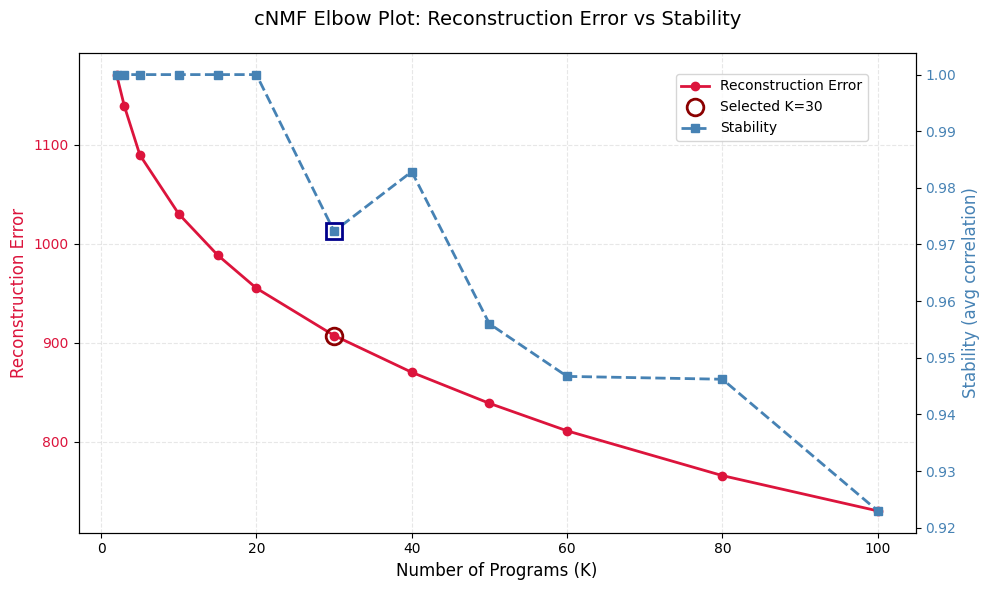

In [64]:
def compute_stability(all_H_matrices):
    """
    Compute stability as pairwise correlation between program spectra across replicates.
    Higher values indicate more stable/consistent programs.
    """
    n_replicates = len(all_H_matrices)
    if n_replicates < 2:
        return 1.0
    
    correlations = []
    for i in range(n_replicates):
        for j in range(i + 1, n_replicates):
            H_i = all_H_matrices[i]
            H_j = all_H_matrices[j]
            # Compute average correlation across programs
            corr_matrix = np.corrcoef(H_i, H_j)[:H_i.shape[0], H_i.shape[0]:]
            # Take the max correlation for each program (accounts for permutation)
            max_corrs = np.max(np.abs(corr_matrix), axis=1)
            correlations.append(np.mean(max_corrs))
    
    return np.mean(correlations)


def run_elbow_analysis(data_matrix, k_values: list, n_replicates=5):
    """
    Run cNMF elbow analysis with stability computation.
    
    Parameters:
    -----------
    data_matrix : array-like
        Expression matrix
    k_values : list
        List of K values to test
    n_replicates : int
        Number of replicates per K value (default: 5)
    """
    errors = []
    stabilities = []
    
    for k in k_values:
        print(f"Testing K={k}...")
        all_W = []
        all_H = []
        recon_errors = []
        
        for i in range(n_replicates):
            model = NMF(n_components=k, init='nndsvd', random_state=42 + i, max_iter=400)
            W = model.fit_transform(data_matrix)
            H = model.components_
            all_W.append(W)
            all_H.append(H)
            recon_errors.append(model.reconstruction_err_)
        
        avg_error = np.mean(recon_errors)
        stability = compute_stability(all_H)
        
        errors.append(avg_error)
        stabilities.append(stability)
        print(f"  K={k}: Error={avg_error:.2f}, Stability={stability:.4f}")
    
    # Plot with dual y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    color_error = 'crimson'
    ax1.set_xlabel("Number of Programs (K)", fontsize=12)
    ax1.set_ylabel("Reconstruction Error", color=color_error, fontsize=12)
    ax1.plot(k_values, errors, marker='o', linestyle='-', color=color_error, linewidth=2, label='Reconstruction Error')
    ax1.tick_params(axis='y', labelcolor=color_error)
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    # Add stability on second y-axis
    ax2 = ax1.twinx()
    color_stability = 'steelblue'
    ax2.set_ylabel("Stability (avg correlation)", color=color_stability, fontsize=12)
    ax2.plot(k_values, stabilities, marker='s', linestyle='--', color=color_stability, linewidth=2, label='Stability')
    ax2.tick_params(axis='y', labelcolor=color_stability)
    
    # Highlight selected K=30
    if 30 in k_values:
        idx = k_values.index(30)
        ax1.plot(30, errors[idx], 'o', color='darkred', markersize=12, markeredgewidth=2, markerfacecolor='none', label='Selected K=30')
        ax2.plot(30, stabilities[idx], 's', color='darkblue', markersize=12, markeredgewidth=2, markerfacecolor='none')
    
    plt.title("cNMF Elbow Plot: Reconstruction Error vs Stability", fontsize=14, pad=20)
    fig.legend(loc='upper right', bbox_to_anchor=(0.88, 0.88))
    fig.tight_layout()
    plt.show()
    
    return errors, stabilities

errors, stabilities = run_elbow_analysis(
    adata_control_unlogged.obsm["X_hvg"],
    k_values=[2, 3, 5, 10, 15, 20, 30, 40, 50, 60, 80, 100],
    n_replicates=5
)

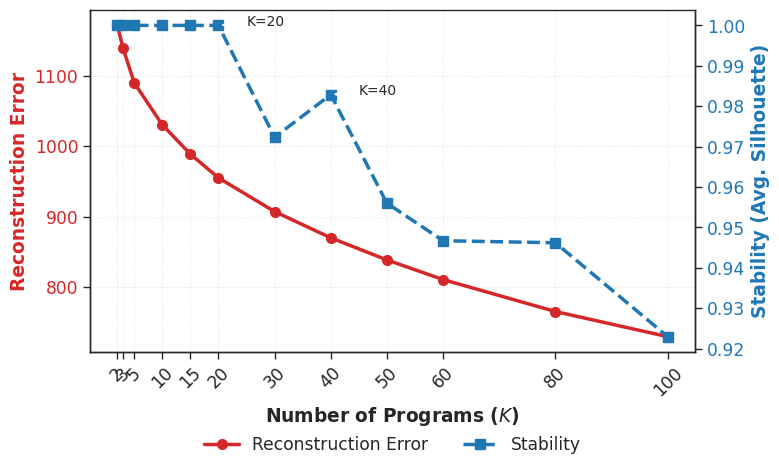

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set publication style
sns.set_context("paper", font_scale=1.4) # Adjust scale for journal (Nature/Science style)
sns.set_style("ticks")

k_values = [2, 3, 5, 10, 15, 20, 30, 40, 50, 60, 80, 100]

# Standard publication figure sizes: 1-column (3.5"), 1.5-column (5"), or 2-column (7")
fig, ax1 = plt.subplots(figsize=(8, 5)) 

# Colors using a professional palette
color_error = '#D62728'  # Refined Crimson
color_stability = '#1F77B4'  # Refined Steelblue

# Axis 1: Reconstruction Error
ax1.set_xlabel("Number of Programs ($K$)", fontweight='bold')
ax1.set_ylabel("Reconstruction Error", color=color_error, fontweight='bold')
line1, = ax1.plot(k_values, errors, marker='o', markersize=7, 
                  linestyle='-', color=color_error, linewidth=2.5, 
                  label='Reconstruction Error')
ax1.tick_params(axis='y', labelcolor=color_error)
ax1.set_xticks(k_values) # Ensure every tested K is visible
plt.xticks(rotation=45)

# Axis 2: Stability
ax2 = ax1.twinx()
ax2.set_ylabel("Stability (Avg. Silhouette)", color=color_stability, fontweight='bold')
line2, = ax2.plot(k_values, stabilities, marker='s', markersize=7, 
                  linestyle='--', color=color_stability, linewidth=2.5, 
                  label='Stability')
ax2.tick_params(axis='y', labelcolor=color_stability)

# Refined Grid and Despine
ax1.grid(visible=True, which='major', axis='both', linestyle=':', alpha=0.5)
sns.despine(ax=ax1, top=True, right=False)

# Publication-grade Legend (Combined from both axes)
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), 
           ncol=2, frameon=False)

# Optional: Highlighting the K=20 and K=40 points
for k in [20, 40]:
    if k in k_values:
        idx = k_values.index(k)
        ax2.annotate(f'K={k}', xy=(k, stabilities[idx]), xytext=(k+5, stabilities[idx]),
                     arrowprops=dict(arrowstyle='->', lw=1), fontsize=10)

plt.tight_layout()

# Save for publication (300+ DPI is standard)
plt.savefig("cNMF_selection_plot.pdf", dpi=300, bbox_inches='tight')
plt.show()

look like K = 20 and 40 are the most promising. we can start with 20

In [23]:
import numpy as np
import pandas as pd

def run_cnmf(data_matrix, n_components, n_replicates=5, random_state=42):
    """
    Run consensus NMF with multiple replicates to improve stability.
    
    Parameters:
    -----------
    data_matrix : array-like
        Expression matrix (cells x genes)
    n_components : int
        Number of programs (K)
    n_replicates : int
        Number of NMF replicates to run (default: 5)
    random_state : int
        Base random seed
    
    Returns:
    --------
    W_consensus : ndarray
        Consensus usage matrix (cells x programs)
    H_consensus : ndarray
        Consensus spectra matrix (programs x genes)
    all_results : list
        List of (W, H) tuples from each replicate
    """
    all_W = []
    all_H = []
    
    for i in range(n_replicates):
        seed = random_state + i
        model = NMF(n_components=n_components, init='nndsvd', random_state=seed, max_iter=500)
        W = model.fit_transform(data_matrix)
        H = model.components_
        all_W.append(W)
        all_H.append(H)
        print(f"  Replicate {i+1}/{n_replicates} complete")
    
    # Compute consensus by averaging across replicates
    W_consensus = np.mean(all_W, axis=0)
    H_consensus = np.mean(all_H, axis=0)
    
    return W_consensus, H_consensus, list(zip(all_W, all_H))


def run_and_save_cnmf(adata, k, replicates=5, hvg_key='X_hvg', random_state=42):
    """
    Wraps run_cnmf, aligns results, and stores them in AnnData.
    """
    print(f"--- Running cNMF for K={k} ---")
    
    # 1. Extract the data matrix
    # Check if data is in .X or an .obsm slot
    if hvg_key == 'X':
        data_matrix = adata.X
    elif hvg_key in adata.obsm:
        data_matrix = adata.obsm[hvg_key]
    else:
        raise ValueError(f"Key '{hvg_key}' not found in adata.X or adata.obsm")

    # Ensure data is dense if it's a sparse matrix (NMF requirement for some inits)
    if hasattr(data_matrix, "toarray"):
        data_matrix = data_matrix.toarray()

    # 2. Run the pre-defined cNMF function
    # W: (Cells x K), H: (K x Genes)
    W_cons, H_cons, _ = run_cnmf(data_matrix, n_components=k, n_replicates=replicates, random_state=random_state)

    # 3. Save Usages to .obsm (Cells x K)
    usage_key = f'cnmf_{k}_usage'
    adata.obsm[usage_key] = W_cons
    
    # 4. Save Loadings to .varm (Genes x K)
    # We transpose H_cons so it aligns with adata.var (Genes)
    loading_key = f'cnmf_{k}_loadings'
    adata.varm[loading_key] = H_cons.T

    # 5. Optional: Store program names in .uns for easy access
    program_names = [f"K{k}_P{i+1}" for i in range(k)]
    adata.uns[f'cnmf_{k}_names'] = program_names

    print(f"Successfully stored results in .obsm['{usage_key}'] and .varm['{loading_key}'].\n")
    return adata

adata_control_unlogged_filtered = adata_control_unlogged[:, HVG_NAMES].copy()

# Assuming your HVGs are in adata.X or stored in an obsm key
# Run for K=20
adata_control_unlogged_filtered = run_and_save_cnmf(
    adata_control_unlogged_filtered, 
    k=20, 
    replicates=10,
    hvg_key='X'
)

# Run for K=40
adata_control_unlogged_filtered = run_and_save_cnmf(
    adata_control_unlogged_filtered, 
    k=40, 
    replicates=10, 
    hvg_key='X'
)

--- Running cNMF for K=20 ---
  Replicate 1/10 complete
  Replicate 2/10 complete
  Replicate 3/10 complete
  Replicate 4/10 complete
  Replicate 5/10 complete
  Replicate 6/10 complete
  Replicate 7/10 complete
  Replicate 8/10 complete
  Replicate 9/10 complete
  Replicate 10/10 complete
Successfully stored results in .obsm['cnmf_20_usage'] and .varm['cnmf_20_loadings'].

--- Running cNMF for K=40 ---
  Replicate 1/10 complete
  Replicate 2/10 complete
  Replicate 3/10 complete
  Replicate 4/10 complete
  Replicate 5/10 complete
  Replicate 6/10 complete
  Replicate 7/10 complete
  Replicate 8/10 complete
  Replicate 9/10 complete
  Replicate 10/10 complete
Successfully stored results in .obsm['cnmf_40_usage'] and .varm['cnmf_40_loadings'].



In [24]:
adata_control_unlogged_filtered.write_h5ad("data/inputs/adata_control_unlogged_filtered_with_cnmf.h5ad")

<Figure size 1600x1000 with 0 Axes>

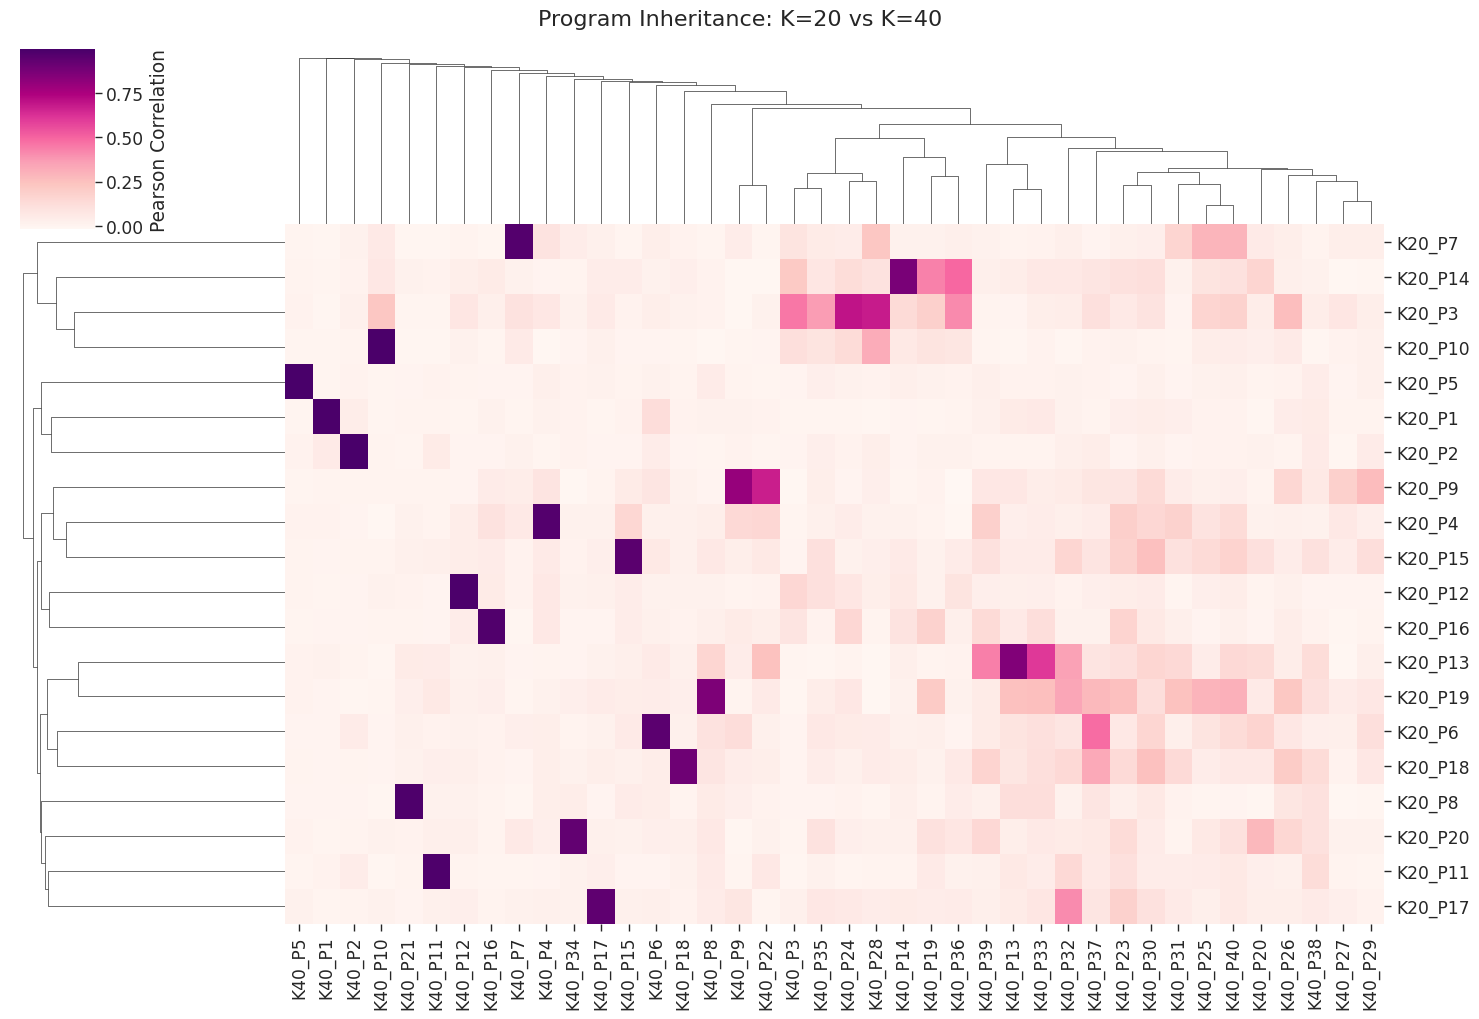

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compare_cnmf_resolutions(adata, k_low=20, k_high=40):
    # 1. Extract the aligned loadings from .varm
    # Shape: (Genes x K)
    w_low = adata.varm[f'cnmf_{k_low}_loadings']
    w_high = adata.varm[f'cnmf_{k_high}_loadings']
    
    # 2. Calculate Pearson Correlation between columns
    # We correlate every K20 program with every K40 program
    corr_matrix = np.corrcoef(w_low.T, w_high.T)[:k_low, k_low:]
    
    # 3. Convert to DataFrame for easier plotting/indexing
    low_names = adata.uns.get(f'cnmf_{k_low}_names', [f"K{k_low}_P{i+1}" for i in range(k_low)])
    high_names = adata.uns.get(f'cnmf_{k_high}_names', [f"K{k_high}_P{i+1}" for i in range(k_high)])
    
    df_corr = pd.DataFrame(corr_matrix, index=low_names, columns=high_names)
    
    # 4. Plotting
    plt.figure(figsize=(16, 10))
    g = sns.clustermap(
        df_corr, 
        cmap="RdPu", 
        standard_scale=None, # Use None to see raw correlation values (0 to 1)
        figsize=(15, 10),
        cbar_kws={'label': 'Pearson Correlation'}
    )
    plt.suptitle(f"Program Inheritance: K={k_low} vs K={k_high}", y=1.02, fontsize=16)
    plt.show()
    
    return df_corr

# Run the comparison
program_corr_df = compare_cnmf_resolutions(adata_control_unlogged_filtered)

### Prep probing magnitude

In [25]:
import numpy as np

def calculate_perturbation_magnitudes(adata, k=20, sigma_multiplier=2.0):
    usage_key = f'cnmf_{k}_usage'
    usages = adata.obsm[usage_key]
    
    # Calculate the standard deviation of each program's usage across cells
    # This gives us a 'unit' of natural variation for each program
    sigmas = np.std(usages, axis=0)
    
    # Magnitudes to use for each program
    magnitudes = sigmas * sigma_multiplier
    
    return magnitudes

# Get the shifts for your 20 programs
magnitudes_20 = calculate_perturbation_magnitudes(adata_control_unlogged_filtered, k=20)
magnitudes_20

array([0.31080329, 0.61764572, 0.33661664, 0.46660211, 0.50599034,
       0.40843294, 0.43392753, 0.35271384, 0.32875041, 0.37188373,
       0.41031362, 0.38083312, 0.33155336, 0.36294102, 0.33102028,
       0.29267419, 0.35208659, 0.33555611, 0.31105721, 0.37992899])

In [26]:
magnitudes_20.mean()

np.float64(0.38106655306258924)

In [27]:
loadings = adata_control_unlogged_filtered.varm['cnmf_20_loadings']
unit_loadings = loadings / np.linalg.norm(loadings, axis=0)
adata_control_unlogged_filtered.varm['cnmf_20_loadings_unit'] = unit_loadings

## Control probing

In [81]:
import scanpy as sc
import numpy as np

def generate_full_probe_stack(adata, k_key='cnmf_20', sigma_multiplier=2.0):
    # 1. Setup paths and base data
    adata_log = adata.copy()
    sc.pp.log1p(adata_log)

    # 2. Extract Loadings and Usages
    loadings = adata_log.varm[f'{k_key}_loadings']
    usage = adata_log.obsm[f'{k_key}_usage']
    n_programs = loadings.shape[1]
    
    # 3. Unit-normalize v and calculate gamma
    unit_v = loadings / np.linalg.norm(loadings, axis=0)
    gammas = np.std(usage, axis=0) * sigma_multiplier
    
    # 4. Create the Stack
    # We will create one copy of the adata for each program + 1 for baseline
    all_adatas = []
    
    # Add Baseline (The (0,0) control)
    baseline = adata_log.copy()
    baseline.obs['probe_id'] = 'baseline'
    all_adatas.append(baseline)
    
    # Add Program Nudges
    for i in range(n_programs):
        nudge_adata = adata_log.copy()
        # Apply the specific program i nudge
        # x_probed = x_orig + gamma_i * v_i
        nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
        
        nudge_adata.obs['probe_id'] = f'program_{i}'
        all_adatas.append(nudge_adata)
        print(f"Prepared probe for {k_key} Program {i}")

    # 5. Concatenate into one massive inference file
    full_stack = sc.concat(all_adatas, index_unique="_")
    
    return full_stack

# Execute automation
full_probed_adata = generate_full_probe_stack(adata_control_unlogged_filtered)
full_probed_adata.write_h5ad("data/inputs/controls_probed_3k_all_K20.h5ad")

/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be 

Prepared probe for cnmf_20 Program 0
Prepared probe for cnmf_20 Program 1
Prepared probe for cnmf_20 Program 2
Prepared probe for cnmf_20 Program 3
Prepared probe for cnmf_20 Program 4
Prepared probe for cnmf_20 Program 5


/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be 

Prepared probe for cnmf_20 Program 6
Prepared probe for cnmf_20 Program 7
Prepared probe for cnmf_20 Program 8
Prepared probe for cnmf_20 Program 9
Prepared probe for cnmf_20 Program 10
Prepared probe for cnmf_20 Program 11


/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be 

Prepared probe for cnmf_20 Program 12
Prepared probe for cnmf_20 Program 13
Prepared probe for cnmf_20 Program 14
Prepared probe for cnmf_20 Program 15
Prepared probe for cnmf_20 Program 16
Prepared probe for cnmf_20 Program 17


/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])
/tmp/ipykernel_508814/2653549697.py:32: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  nudge_adata.X = nudge_adata.X + (gammas[i] * unit_v[:, i])


Prepared probe for cnmf_20 Program 18
Prepared probe for cnmf_20 Program 19


In [82]:
!state tx infer_controls \
  --adata data/inputs/controls_probed_3k_all_K20.h5ad \
  --model-dir ./ST-Tahoe \
  --target-pert "[('DMSO_TF', 0.0, 'uM')]" \
  --output data/outputs/controls_probed_all_K20.h5ad

==> STATE: Apply '[('DMSO_TF', 0.0, 'uM')]' to control cells
Loading model from ./ST-Tahoe/final_from_preprint.ckpt
StateTransitionPerturbationModel(
  (loss_fn): SamplesLoss()
  (pert_encoder): Sequential(
    (0): Linear(in_features=1138, out_features=1488, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1488, out_features=1488, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=1488, out_features=1488, bias=True)
    (7): GELU(approximate='none')
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=1488, out_features=1488, bias=True)
  )
  (basal_encoder): Sequential(
    (0): Linear(in_features=2000, out_features=1488, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1488, out_features=1488, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.1, inplace=False)
    (6): 

In [13]:
import pandas as pd
import numpy as np

# Load the result from the tx infer_controls run
out = sc.read_h5ad("data/outputs/controls_probed_all_K20.h5ad")

# Access the predictions from the correct layer
pred_layer_key = "pred_[('DMSO_TF', 0.0, 'uM')]"

# 1. Get the Baseline State (x_hat_baseline)
# This is what the model thinks the un-nudged control cells look like post-inference
baseline_mask = out.obs['probe_id'] == 'baseline'
baseline_pred = out[baseline_mask].layers[pred_layer_key].mean(axis=0)

sensitivity_results = []

for i in range(20):
    # 2. Get the Probed State (x_hat_probed)
    # This is the model's prediction for the cells you nudged by gamma * v
    prog_mask = out.obs['probe_id'] == f'program_{i}'
    prog_pred = out[prog_mask].layers[pred_layer_key].mean(axis=0)
    
    # 3. YOUR FORMULA: S = || x_hat_probed - x_hat_baseline ||
    # This is the total distance the model moved the cell in gene-space
    s_score = np.linalg.norm(prog_pred - baseline_pred)
    
    sensitivity_results.append({
        'program': f'P{i}',
        'sensitivity': s_score
    })

ranking_df = pd.DataFrame(sensitivity_results).sort_values('sensitivity', ascending=False)
print(ranking_df)

   program  sensitivity
2       P2     0.435652
19     P19     0.376334
9       P9     0.363330
1       P1     0.355274
8       P8     0.328269
13     P13     0.327731
18     P18     0.320108
6       P6     0.311970
12     P12     0.305648
7       P7     0.303776
4       P4     0.298750
16     P16     0.295486
11     P11     0.281064
5       P5     0.279430
3       P3     0.273012
15     P15     0.272371
0       P0     0.261968
10     P10     0.246498
14     P14     0.238695
17     P17     0.225670


In [28]:
def annotate_programs_comprehensive(adata, k=20, top_n_genes=100, top_n_display=6, n_go_terms=5):
    """
    Comprehensive program annotation combining GO enrichment and detailed gene analysis.
    
    Parameters:
    -----------
    adata : AnnData
        AnnData object with cNMF results
    k : int
        Number of programs
    top_n_genes : int
        Number of top genes to use for GO enrichment
    top_n_display : int
        Number of top genes to display and store (default: 6)
    n_go_terms : int
        Number of GO terms to store per program (default: 5)
        
    Returns:
    --------
    adata : AnnData
        Modified AnnData object with both simple and detailed annotations
    """
    import gseapy as gp
    import pandas as pd
    import numpy as np
    
    # Get the loadings for specified K
    loadings = adata.varm[f'cnmf_{k}_loadings']
    gene_names = adata.var_names
    
    # Storage for both annotation types
    simple_annotations = {}
    detailed_annotations = {}
    
    print(f"Running comprehensive program annotation for K={k}...")
    print("=" * 80)
    
    for prog_idx in range(k):
        print(f"\nPROGRAM P{prog_idx}")
        print("-" * 80)
        
        # Get loadings for this program
        prog_loadings = loadings[:, prog_idx]
        
        # Get top genes for display
        top_display_indices = np.argsort(prog_loadings)[::-1][:top_n_display]
        top_display_genes = gene_names[top_display_indices].tolist()
        top_display_values = prog_loadings[top_display_indices]
        
        # Store ranked genes with loadings
        ranked_genes = {
            gene: float(loading) 
            for gene, loading in zip(top_display_genes, top_display_values)
        }
        
        print(f"Top {top_n_display} Genes:")
        for i, (gene, value) in enumerate(zip(top_display_genes, top_display_values), 1):
            print(f"  {i}. {gene:15s} (loading: {value:.4f})")
        
        # Run GSEA on top N genes
        print(f"\nGO Enrichment (top {top_n_genes} genes):")
        
        top_enrichment_indices = np.argsort(prog_loadings)[::-1][:top_n_genes]
        top_enrichment_genes = gene_names[top_enrichment_indices].tolist()
        
        gsea_terms = []
        program_name = f"Program {prog_idx}"
        
        try:
            enr = gp.enrichr(
                gene_list=top_enrichment_genes,
                gene_sets=['GO_Biological_Process_2023'],
                organism='human',
                outdir=None
            )
            
            # Display and store top N enriched terms
            top_results = enr.results.head(n_go_terms)
            for idx, row in top_results.iterrows():
                term = row['Term'].split(' (GO')[0]
                p_val = row['Adjusted P-value']
                gsea_terms.append({
                    'term': term,
                    'p_value': float(p_val),
                    'genes': row['Genes']
                })
                print(f"  • {term} (p={p_val:.2e})")
            
            # Use top term as program name
            if gsea_terms:
                program_name = gsea_terms[0]['term']
                
        except Exception as e:
            print(f"  Error running enrichment: {e}")
            gsea_terms = []
            program_name = f"Program {prog_idx} (Unknown)"
        
        # Store simple annotation
        simple_annotations[f'P{prog_idx}'] = program_name
        
        # Store comprehensive information
        detailed_annotations[f'P{prog_idx}'] = {
            'name': program_name,
            'top_genes': ranked_genes,
            'gsea_terms': gsea_terms
        }
    
    # Store both annotation types in adata.uns
    adata.uns[f'cnmf_{k}_go_annotations'] = simple_annotations
    adata.uns[f'cnmf_{k}_detailed_annotations'] = detailed_annotations
    
    print(f"\n{'='*80}")
    print(f"✓ Simple annotations stored in .uns['cnmf_{k}_go_annotations']")
    print(f"✓ Detailed annotations stored in .uns['cnmf_{k}_detailed_annotations']")
    print(f"{'='*80}\n")
    
    return adata

# Run comprehensive annotation
adata_control_unlogged_filtered = annotate_programs_comprehensive(
    adata_control_unlogged_filtered, 
    k=20,
    top_n_genes=100,
    top_n_display=6,
    n_go_terms=5
)

Running comprehensive program annotation for K=20...

PROGRAM P0
--------------------------------------------------------------------------------
Top 6 Genes:
  1. FN1             (loading: 28.8344)
  2. PLOD2           (loading: 1.2159)
  3. SERPINE2        (loading: 1.1799)
  4. HLA-B           (loading: 0.9957)
  5. TIMP3           (loading: 0.9829)
  6. PTPRM           (loading: 0.9078)

GO Enrichment (top 100 genes):
  • Extracellular Matrix Organization (p=2.33e-05)
  • Collagen Fibril Organization (p=2.45e-05)
  • Extracellular Structure Organization (p=2.45e-05)
  • External Encapsulating Structure Organization (p=2.45e-05)
  • Regulation Of Cell Migration (p=4.35e-04)

PROGRAM P1
--------------------------------------------------------------------------------
Top 6 Genes:
  1. IGF2            (loading: 16.7272)
  2. SERPINA1        (loading: 2.2736)
  3. C3              (loading: 1.8068)
  4. SERPINA3        (loading: 1.4828)
  5. FN1             (loading: 0.9716)
  6. PLOD2  

In [37]:
# revise program annotations - assisted by Gemini
adata_control_unlogged_filtered.uns["cnmf_20_go_annotations"] = {
    'P0': 'Mesenchymal-like/EMT State',
    'P1': 'IGF2-Driven Growth Signaling',
    'P2': 'Epithelial Adhesion & Barrier Integrity',
    'P3': 'Cyclic Nucleotide-Regulated Matrix Remodeling',
    'P4': 'Quiescent/Wound-Response State',
    'P5': 'Migratory Cytoskeletal Organization',
    'P6': 'Axon Guidance-like Developmental Signaling',
    'P7': 'IGFBP-Related Stromal Interaction',
    'P8': 'Neurotransmission & Synaptic-like Signaling',
    'P9': 'Wnt/Beta-Catenin Survival Signaling',
    'P10': 'Hypoxia-Induced Angiogenic Switch',
    'P11': 'RTK Driver Signaling (EGFR/MET)',
    'P12': 'Desmoplastic Collagen Organization',
    'P13': 'Cell-Cell Junctional Stability',
    'P14': 'Neuroendocrine-like Differentiation',
    'P15': 'Complement-Mediated Immune Evasion',
    'P16': 'Ribosomal Stress & Anti-Apoptosis',
    'P17': 'Pro-Tumorigenic Inflammatory Response',
    'P18': 'SPARC-Mediated Matrix Stiffness',
    'P19': 'Metallothionein-Mediated Metal Stress'
}

In [39]:
import json

# Convert detailed_annotations to be HDF5-compatible by serializing complex structures to JSON
if 'cnmf_20_detailed_annotations' in adata_control_unlogged_filtered.uns:
    detailed_annot = adata_control_unlogged_filtered.uns['cnmf_20_detailed_annotations']
    
    # Create a serializable version
    serializable_detailed_annot = {}
    for prog_id, info in detailed_annot.items():
        serializable_detailed_annot[prog_id] = {
            'name': info['name'],
            'top_genes': json.dumps(info['top_genes']),  # Convert dict to JSON string
            'gsea_terms': json.dumps(info['gsea_terms'])  # Convert list of dicts to JSON string
        }
    
    # Replace with serializable version
    adata_control_unlogged_filtered.uns['cnmf_20_detailed_annotations'] = serializable_detailed_annot
    print("✓ Converted detailed annotations to HDF5-compatible format")
adata_control_unlogged_filtered.write_h5ad("data/outputs/controls_with_k20_annotation.h5ad")

✓ Converted detailed annotations to HDF5-compatible format


### plotting programs by sensitivity

<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_593009/820842880.py:57: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Sensitivity Score ($\mathcal{S}$)", fontsize=12)


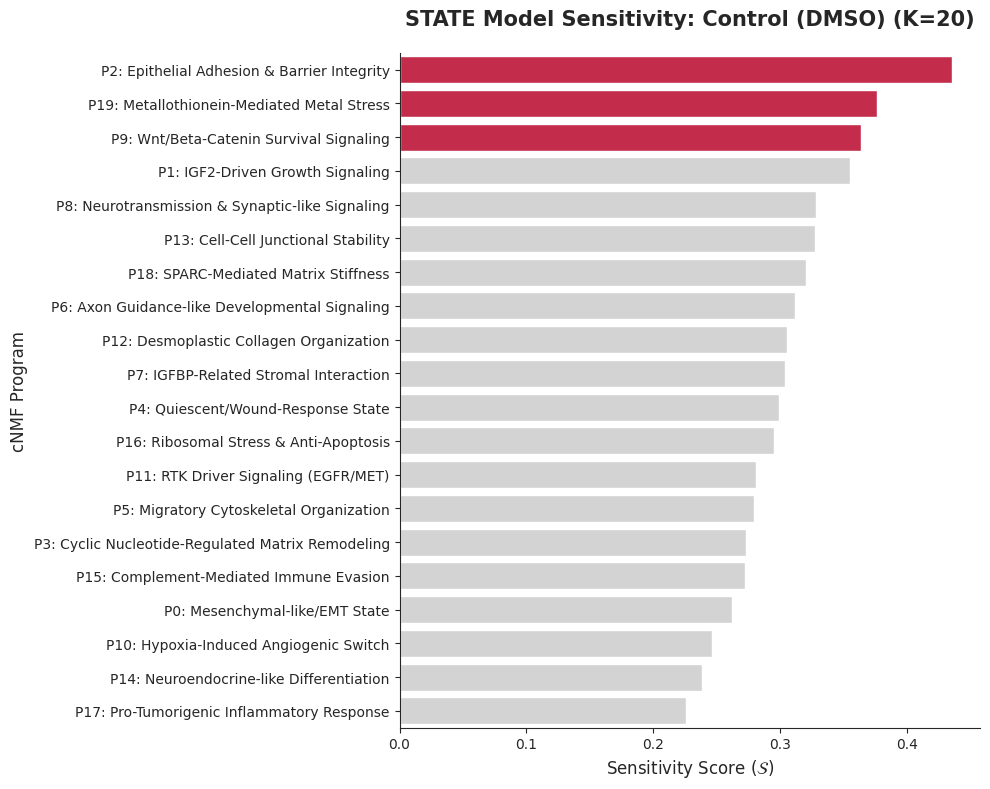

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_sensitivity_ranking(adata, ranking_df, k=20, perturbation_name="Control"):
    """
    Plots ranked sensitivity using stored GO annotations from adata.uns
    
    Parameters:
    -----------
    adata : AnnData
        AnnData object with GO annotations in .uns
    ranking_df : DataFrame
        DataFrame with 'program' and 'sensitivity' columns
    k : int
        Number of programs
    perturbation_name : str
        Name of perturbation for plot title
    """
    # 1. Get GO annotations directly from adata.uns
    go_annotations = adata.uns.get(f'cnmf_{k}_go_annotations', {})
    
    if not go_annotations:
        print(f"⚠️ No GO annotations found in .uns['cnmf_{k}_go_annotations']")
        print("   Using program IDs only.")
        # Fallback to just program names
        annotations = {prog: prog for prog in ranking_df['program']}
    else:
        # Use the GO annotations directly (they're already just program_id: name mappings)
        annotations = go_annotations

    # 2. Merge annotations with ranking_df
    ranking_df = ranking_df.copy()
    ranking_df['Annotation'] = ranking_df['program'].map(annotations)
    # If annotation not found, use the program ID
    ranking_df['Annotation'] = ranking_df['Annotation'].fillna(ranking_df['program'])
    ranking_df['Label'] = ranking_df['program'] + ": " + ranking_df['Annotation']

    # 3. Plotting
    plt.figure(figsize=(10, 8))
    sns.set_style("ticks")
    
    # Color mapping: Highlight top 3 high-sensitivity programs
    colors = ['crimson' if i < 3 else 'lightgrey' for i in range(len(ranking_df))]
    
    ax = sns.barplot(
        data=ranking_df, 
        x='sensitivity', 
        y='Label', 
        palette=colors,
        hue='Label',
        legend=False
    )

    plt.title(f"STATE Model Sensitivity: {perturbation_name} (K={k})", fontsize=15, fontweight='bold', pad=20)
    plt.xlabel("Sensitivity Score ($\mathcal{S}$)", fontsize=12)
    plt.ylabel("cNMF Program", fontsize=12)
    sns.despine()
    plt.tight_layout()
    
    plt.savefig(f"plots/Program_Sensitivity_{perturbation_name}.pdf", dpi=300)
    plt.show()

    return ranking_df

# Run the pipeline for control
final_ranking_control = plot_sensitivity_ranking(
    adata_control_unlogged_filtered, 
    ranking_df, 
    perturbation_name="Control (DMSO)"
)

### Trametinib probing

In [45]:
# Load the perturbation one-hot mapping from the downloaded model
import pickle

model_dir = "./ST-Tahoe"
pert_onehot_map_path = os.path.join(model_dir, "pert_onehot_map.pt")

print(f"Loading perturbation vocabulary from: {pert_onehot_map_path}")
pert_onehot_map = torch.load(pert_onehot_map_path, weights_only=False)

print(f"✓ Loaded {len(pert_onehot_map)} perturbations")
print(f"\nAvailable drugs (first 10): {list(pert_onehot_map.keys())[:10]}")

# Check if target drug is in vocabulary
target_drug = "Trametinib"
if target_drug in pert_onehot_map:
    print(f"✓ '{target_drug}' found in vocabulary")
else:
    # Try case-insensitive search
    matching = [k for k in pert_onehot_map.keys() if target_drug.lower() in k.lower()]
    if matching:
        print(f"⚠️  Exact match not found, but found similar: {matching}")
    else:
        print(f"⚠️  '{target_drug}' not found in vocabulary")


Loading perturbation vocabulary from: ./ST-Tahoe/pert_onehot_map.pt
✓ Loaded 1138 perturbations

Available drugs (first 10): [np.str_("[('(R)-Verapamil (hydrochloride)', 0.05, 'uM')]"), np.str_("[('(R)-Verapamil (hydrochloride)', 0.5, 'uM')]"), np.str_("[('(R)-Verapamil (hydrochloride)', 5.0, 'uM')]"), np.str_("[('(S)-Crizotinib', 0.05, 'uM')]"), np.str_("[('(S)-Crizotinib', 0.5, 'uM')]"), np.str_("[('(S)-Crizotinib', 5.0, 'uM')]"), np.str_("[('18β-Glycyrrhetinic acid', 0.05, 'uM')]"), np.str_("[('18β-Glycyrrhetinic acid', 0.5, 'uM')]"), np.str_("[('18β-Glycyrrhetinic acid', 5.0, 'uM')]"), np.str_("[('4EGI-1', 0.05, 'uM')]")]
⚠️  Exact match not found, but found similar: [np.str_("[('Trametinib (DMSO_TF solvate)', 0.05, 'uM')]"), np.str_("[('Trametinib (DMSO_TF solvate)', 0.5, 'uM')]"), np.str_("[('Trametinib (DMSO_TF solvate)', 5.0, 'uM')]"), np.str_("[('Trametinib', 0.05, 'uM')]"), np.str_("[('Trametinib', 0.5, 'uM')]"), np.str_("[('Trametinib', 5.0, 'uM')]")]


In [104]:
# TODO try to make it so this is with the drug cong column
inputs = anndata.read_h5ad("data/inputs/controls_probed_3k_all_K20.h5ad")
inputs.obs["drugname_drugconc"] = "[('Trametinib', 5.0, 'nM')]"
drug_meta = drug_metadata[drug_metadata["drug"] == "Trametinib"][["canonical_smiles", "pubchem_cid"]]

# Extract scalar values and broadcast to all cells
canonical_smiles_val = str(drug_meta["canonical_smiles"].iloc[0])
pubchem_cid_val = drug_meta["pubchem_cid"].iloc[0]

inputs.obs["canonical_smiles"] = canonical_smiles_val
inputs.obs["pubchem_cid"] = pubchem_cid_val
inputs.obs["treatment"] = "[('Trametinib', 5.0, 'nM')]"
inputs.obs["drug"] = "Trametinib"
inputs.write_h5ad("data/inputs/controls_probed_3k_all_K20_trametinib.h5ad")

In [105]:
!state tx infer_controls \
  --adata data/inputs/controls_probed_3k_all_K20_trametinib.h5ad \
  --model-dir ./ST-Tahoe \
  --target-pert "[('Trametinib', 5.0, 'uM')]" \
  --output data/outputs/trametinib_probed_all_K20.h5ad

==> STATE: Apply '[('Trametinib', 5.0, 'uM')]' to control cells
Loading model from ./ST-Tahoe/final_from_preprint.ckpt
StateTransitionPerturbationModel(
  (loss_fn): SamplesLoss()
  (pert_encoder): Sequential(
    (0): Linear(in_features=1138, out_features=1488, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1488, out_features=1488, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=1488, out_features=1488, bias=True)
    (7): GELU(approximate='none')
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=1488, out_features=1488, bias=True)
  )
  (basal_encoder): Sequential(
    (0): Linear(in_features=2000, out_features=1488, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1488, out_features=1488, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.1, inplace=False)
    (6

In [46]:
import pandas as pd
import numpy as np
import scanpy as sc

def calculate_drug_sensitivity(output_path, drug_pert_key, k=20):
    # Load the Trametinib inference results
    out_drug = sc.read_h5ad(output_path)
    
    # Access the predictions from the correct layer
    pred_layer_key = f"pred_{drug_pert_key}"
    
    # 1. Get the Baseline Drug Prediction (no nudge)
    # This is the "average" response to Trametinib
    baseline_mask = out_drug.obs['probe_id'] == 'baseline'
    baseline_drug_pred = out_drug[baseline_mask].layers[pred_layer_key].mean(axis=0)
    
    drug_sensitivity_results = []

    for i in range(k):
        # 2. Get the Nudged Drug Prediction
        prog_mask = out_drug.obs['probe_id'] == f'program_{i}'
        prog_pred = out_drug[prog_mask].layers[pred_layer_key].mean(axis=0)
        
        # 3. Calculate Sensitivity S = || Drug_Pred_Nudged - Drug_Pred_Baseline ||
        s_score = np.linalg.norm(prog_pred - baseline_drug_pred)
        
        drug_sensitivity_results.append({
            'program': f'P{i}',
            'sensitivity_trametinib': s_score
        })
        
    return pd.DataFrame(drug_sensitivity_results)

# Run the calculation
trametinib_ranking = calculate_drug_sensitivity(
    "data/outputs/trametinib_probed_all_K20.h5ad",
    drug_pert_key="[('Trametinib', 5.0, 'uM')]"
)

In [47]:
trametinib_ranking

,program,sensitivity_trametinib
0,P0,0.274943
1,P1,0.325714
2,P2,0.361971
3,P3,0.275172
4,P4,0.289501
5,P5,0.328188
6,P6,0.320991
7,P7,0.301048
8,P8,0.360254
9,P9,0.344972


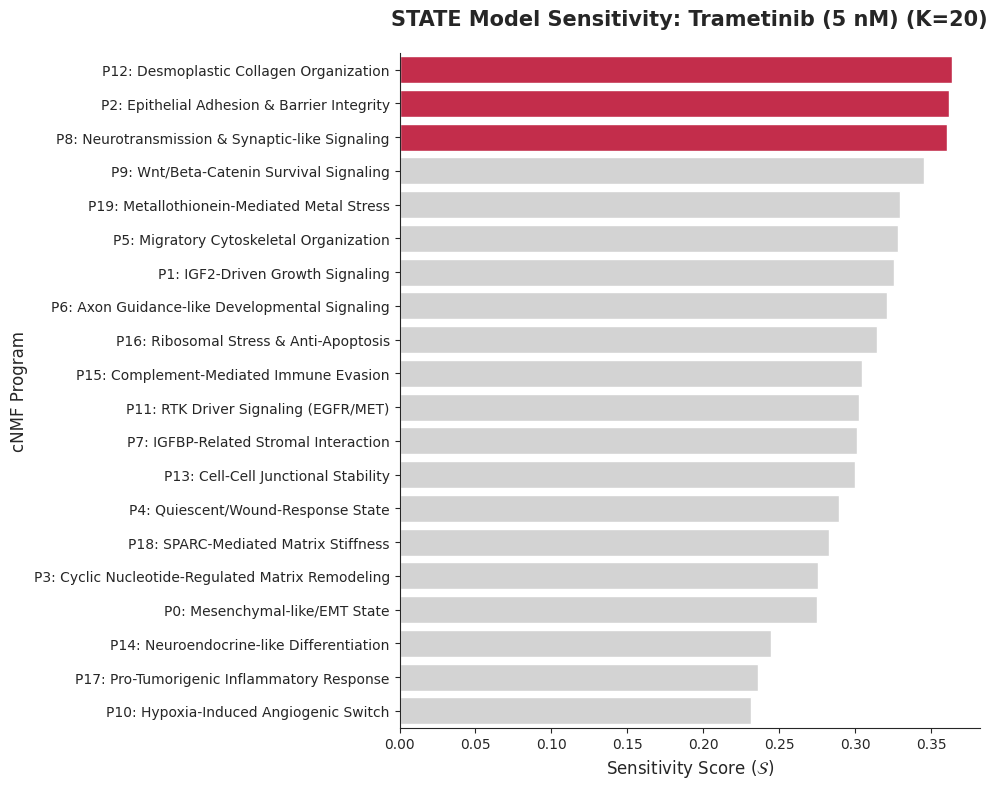

In [48]:
# Plot Trametinib sensitivity with annotations
trametinib_ranking_sorted = trametinib_ranking.sort_values('sensitivity_trametinib', ascending=False)
trametinib_ranking_sorted = trametinib_ranking_sorted.rename(columns={'sensitivity_trametinib': 'sensitivity'})

final_ranking_trametinib = plot_sensitivity_ranking(
    adata_control_unlogged_filtered, 
    trametinib_ranking_sorted, 
    perturbation_name="Trametinib (5 nM)"
)

In [49]:
import pandas as pd
import json

def print_detailed_sensitivity_report(adata, control_ranking, drug_ranking, k=20, drug_name="Trametinib"):
    """
    Print a comprehensive, formatted report of program sensitivity rankings
    """
    # Get annotations
    go_annotations = adata.uns.get(f'cnmf_{k}_go_annotations', {})
    detailed_annotations = adata.uns.get(f'cnmf_{k}_detailed_annotations', {})
    
    print("=" * 100)
    print(f"STATE MODEL SENSITIVITY ANALYSIS: cNMF Programs (K={k})")
    print("=" * 100)
    print()
    
    # Merge the two rankings
    merged_df = pd.merge(
        control_ranking[['program', 'sensitivity']].rename(columns={'sensitivity': 'control_sensitivity'}),
        drug_ranking[['program', 'sensitivity']].rename(columns={'sensitivity': f'{drug_name.lower()}_sensitivity'}),
        on='program'
    )
    
    # Add annotations
    merged_df['annotation'] = merged_df['program'].map(go_annotations)
    
    # Calculate difference (how much more sensitive to drug vs control)
    merged_df['delta'] = merged_df[f'{drug_name.lower()}_sensitivity'] - merged_df['control_sensitivity']
    
    # Sort by drug sensitivity
    merged_df = merged_df.sort_values(f'{drug_name.lower()}_sensitivity', ascending=False)
    
    print("RANKED BY DRUG SENSITIVITY")
    print("-" * 100)
    print(f"{'Rank':<6}{'Program':<10}{'Annotation':<45}{'Control':<12}{drug_name:<12}{'Δ (Drug-Ctrl)':<15}")
    print("-" * 100)
    
    for idx, row in enumerate(merged_df.itertuples(), 1):
        prog_id = row.program
        annotation = row.annotation if row.annotation else "Unknown"
        ctrl_sens = row.control_sensitivity
        drug_sens = getattr(row, f'{drug_name.lower()}_sensitivity')
        delta = row.delta
        
        print(f"{idx:<6}{prog_id:<10}{annotation[:43]:<45}{ctrl_sens:<12.4f}{drug_sens:<12.4f}{delta:<15.4f}")
    
    print()
    print("=" * 100)
    print("DETAILED PROGRAM INFORMATION")
    print("=" * 100)
    print()
    
    # Print detailed info for each program
    for idx, row in enumerate(merged_df.itertuples(), 1):
        prog_id = row.program
        annotation = row.annotation if row.annotation else "Unknown"
        ctrl_sens = row.control_sensitivity
        drug_sens = getattr(row, f'{drug_name.lower()}_sensitivity')
        delta = row.delta
        
        print(f"RANK #{idx}: {prog_id} - {annotation}")
        print("-" * 100)
        print(f"  Control Sensitivity:     {ctrl_sens:.4f}")
        print(f"  {drug_name} Sensitivity: {drug_sens:.4f}")
        print(f"  Δ (Drug - Control):      {delta:+.4f}")
        
        # Add top genes if available
        if detailed_annotations and prog_id in detailed_annotations:
            details = detailed_annotations[prog_id]
            top_genes_str = details.get('top_genes', '{}')
            
            # Parse JSON if it's a string
            if isinstance(top_genes_str, str):
                try:
                    top_genes = json.loads(top_genes_str)
                except:
                    top_genes = {}
            else:
                top_genes = top_genes_str
            
            if top_genes:
                print(f"  Top Marker Genes:")
                for i, (gene, loading) in enumerate(list(top_genes.items())[:6], 1):
                    print(f"    {i}. {gene:<15s} (loading: {loading:.4f})")
            
            # Add GO terms if available
            gsea_terms_str = details.get('gsea_terms', '[]')
            if isinstance(gsea_terms_str, str):
                try:
                    gsea_terms = json.loads(gsea_terms_str)
                except:
                    gsea_terms = []
            else:
                gsea_terms = gsea_terms_str
            
            if gsea_terms and len(gsea_terms) > 0:
                print(f"  Top GO Enrichments:")
                for i, term_info in enumerate(gsea_terms[:3], 1):
                    term_name = term_info.get('term', 'Unknown')
                    p_val = term_info.get('p_value', 1.0)
                    print(f"    {i}. {term_name} (p={p_val:.2e})")
        
        print()
    
    print("=" * 100)
    print("SUMMARY STATISTICS")
    print("=" * 100)
    print(f"Mean Control Sensitivity:     {merged_df['control_sensitivity'].mean():.4f} ± {merged_df['control_sensitivity'].std():.4f}")
    print(f"Mean {drug_name} Sensitivity: {merged_df[f'{drug_name.lower()}_sensitivity'].mean():.4f} ± {merged_df[f'{drug_name.lower()}_sensitivity'].std():.4f}")
    print(f"Mean Δ (Drug - Control):      {merged_df['delta'].mean():.4f} ± {merged_df['delta'].std():.4f}")
    print()
    
    # Identify top movers
    print("TOP 5 DRUG-SPECIFIC RESPONDERS (Highest Δ):")
    top_specific = merged_df.nlargest(5, 'delta')
    for idx, row in enumerate(top_specific.itertuples(), 1):
        print(f"  {idx}. {row.program}: {row.annotation} (Δ = {row.delta:+.4f})")
    
    print()
    return merged_df

# Generate the detailed report
detailed_report = print_detailed_sensitivity_report(
    adata_control_unlogged_filtered,
    final_ranking_control,
    final_ranking_trametinib,
    drug_name="Trametinib"
)

# Optionally save to CSV for easy sharing
detailed_report.to_csv("data/outputs/sensitivity_analysis_detailed.csv", index=False)
print("\n✓ Report saved to data/outputs/sensitivity_analysis_detailed.csv")

STATE MODEL SENSITIVITY ANALYSIS: cNMF Programs (K=20)

RANKED BY DRUG SENSITIVITY
----------------------------------------------------------------------------------------------------
Rank  Program   Annotation                                   Control     Trametinib  Δ (Drug-Ctrl)  
----------------------------------------------------------------------------------------------------
1     P12       Desmoplastic Collagen Organization           0.3056      0.3639      0.0583         
2     P2        Epithelial Adhesion & Barrier Integrity      0.4357      0.3620      -0.0737        
3     P8        Neurotransmission & Synaptic-like Signaling  0.3283      0.3603      0.0320         
4     P9        Wnt/Beta-Catenin Survival Signaling          0.3633      0.3450      -0.0184        
5     P19       Metallothionein-Mediated Metal Stress        0.3763      0.3294      -0.0469        
6     P5        Migratory Cytoskeletal Organization          0.2794      0.3282      0.0488         
7     P1